09.3 Agglomerative Hierarchical Clustering - LICA

Author: Alexperezm | Master's End of Degree Project - 2021-2022

Objective: Based on gene expression, patients will be clustered, rising an agglomerative hierarchical clustering model, which given its tree shape, will be cut in several heights, to study if those clusters that have been developed based only on expression data, have significant differences on our query variable (Overall Survival).


Loading libraries:

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
import scipy.cluster.hierarchy as sch

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Definition of the plot_dendogram function, self-explanatory.

In [ ]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

Loading of the gene expression dataset:

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/TFM/Jessica_subread_counts.xlsx")
df.head()

,Geneid,CHC3825T,CHC3864T,CHC3880T,CHC3894T,CHC3914T,CHC4041T,CHC4042T,CHC4043T,CHC4046T,...,CHC1731T,CHC1753T,CHC1994T,CHC2043T,CHC2128T,CHC2844T,CHC2899T,CHC3029T,CHC3788T,CHC3798T
0,ENSG00000223972.5,1,0,4,8,0,0,0,2,4,...,0,0,11,1,2,1,6,3,1,3
1,ENSG00000227232.5,93,17,27,46,14,3,52,23,17,...,61,14,91,59,36,18,58,81,72,19
2,ENSG00000278267.1,16,23,5,24,6,0,8,27,1,...,8,0,28,30,20,18,29,22,26,3
3,ENSG00000243485.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000284332.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Basic changes to adjust the dataset for the clustering procedure:

In [ ]:
colnames = df["Geneid"]

In [ ]:
colnames

0        ENSG00000223972.5
1        ENSG00000227232.5
2        ENSG00000278267.1
3        ENSG00000243485.5
4        ENSG00000284332.1
               ...        
58283    ENSG00000198695.2
58284    ENSG00000210194.1
58285    ENSG00000198727.2
58286    ENSG00000210195.2
58287    ENSG00000210196.2
Name: Geneid, Length: 58288, dtype: object

In [ ]:
PatientID=(df.columns)

In [ ]:
del df["Geneid"]
X = df.transpose()
X.columns = colnames

In [ ]:
X

Geneid,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000284332.1,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.2,ENSG00000186092.5,ENSG00000238009.6,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
CHC3825T,1,93,16,0,0,0,0,0,0,1,...,2005667,0,0,0,541836,99858,0,1022461,0,7434
CHC3864T,0,17,23,0,0,0,0,0,1,1,...,1775069,0,0,0,504519,116822,0,1170266,0,5947
CHC3880T,4,27,5,0,0,0,0,0,0,2,...,765461,0,0,0,315831,56916,0,355600,0,3150
CHC3894T,8,46,24,0,0,0,0,0,0,6,...,2665963,0,0,0,547571,73834,0,1274406,0,7232
CHC3914T,0,14,6,0,0,0,0,0,0,2,...,657467,0,0,0,385659,84045,0,220353,0,5223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHC2844T,1,18,18,0,0,0,0,0,0,1,...,2712782,0,0,0,969243,189921,0,1514244,0,8224
CHC2899T,6,58,29,0,0,0,0,0,0,11,...,1169707,0,0,0,470190,79464,0,600831,0,2839
CHC3029T,3,81,22,0,0,0,0,0,0,12,...,693848,0,0,0,192003,35830,0,278589,0,3008
CHC3788T,1,72,26,0,0,0,0,0,0,8,...,1002591,0,0,0,278985,48507,0,309521,0,5415


In [ ]:
# Escalado de datos
# ==============================================================================
X_scaled_0 = scale(X, axis=0) 
#X_scaled_1 = scale(X, axis=1)

In [ ]:
type(X_scaled_0)

numpy.ndarray

In [ ]:
X_scaled = pd.DataFrame(X_scaled_0)
X_scaled.columns = colnames

In [ ]:
X_scaled

Geneid,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000284332.1,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.2,ENSG00000186092.5,ENSG00000238009.6,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
0,-0.219171,-0.629243,-0.226167,-0.389332,0.0,-0.272592,-0.106332,-0.200967,-0.263359,-0.781829,...,0.190103,0.0,0.0,-0.079057,-0.062682,-0.327645,0.0,0.118813,0.0,0.457492
1,-0.287956,-1.215373,0.209543,-0.389332,0.0,-0.272592,-0.106332,-0.200967,0.536656,-0.781829,...,-0.048390,0.0,0.0,-0.079057,-0.150157,-0.183139,0.0,0.375422,0.0,0.109591
2,-0.012817,-1.138251,-0.910854,-0.389332,0.0,-0.272592,-0.106332,-0.200967,-0.263359,-0.630900,...,-1.092566,0.0,0.0,-0.079057,-0.592461,-0.693441,0.0,-1.038947,0.0,-0.544799
3,0.262322,-0.991718,0.271787,-0.389332,0.0,-0.272592,-0.106332,-0.200967,-0.263359,-0.027186,...,0.873007,0.0,0.0,-0.079057,-0.049239,-0.549327,0.0,0.556223,0.0,0.410232
4,-0.287956,-1.238510,-0.848610,-0.389332,0.0,-0.272592,-0.106332,-0.200967,-0.263359,-0.630900,...,-1.204257,0.0,0.0,-0.079057,-0.428777,-0.462346,0.0,-1.273754,0.0,-0.059797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,-0.219171,-1.207661,-0.101679,-0.389332,0.0,-0.272592,-0.106332,-0.200967,-0.263359,-0.781829,...,0.921429,0.0,0.0,-0.079057,0.939204,0.439547,0.0,0.972614,0.0,0.642321
157,0.124752,-0.899171,0.583008,-0.389332,0.0,-0.272592,-0.106332,-0.200967,-0.263359,0.727457,...,-0.674479,0.0,0.0,-0.079057,-0.230628,-0.501369,0.0,-0.613193,0.0,-0.617561
158,-0.081602,-0.721790,0.147299,-0.389332,0.0,-0.272592,-0.106332,-0.200967,-0.263359,0.878386,...,-1.166631,0.0,0.0,-0.079057,-0.882727,-0.873060,0.0,-1.172648,0.0,-0.578021
159,-0.219171,-0.791200,0.396276,-0.389332,0.0,-0.272592,-0.106332,-0.200967,-0.263359,0.274671,...,-0.847317,0.0,0.0,-0.079057,-0.678832,-0.765073,0.0,-1.118946,0.0,-0.014876


In [ ]:
X_scaled.shape

(161, 58288)

First of all, three different models are developed and visualized, each with different properties, being further explained in the memoir of this project; For our purpose, the "modelo_hclust_ward" will be used.

In [ ]:
# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'complete',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_complete.fit(X=X_scaled)

modelo_hclust_average = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'average',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_average.fit(X=X_scaled)

modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = 0,
                            n_clusters         = None                           
                     )
modelo_hclust_ward.fit(X=X_scaled)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

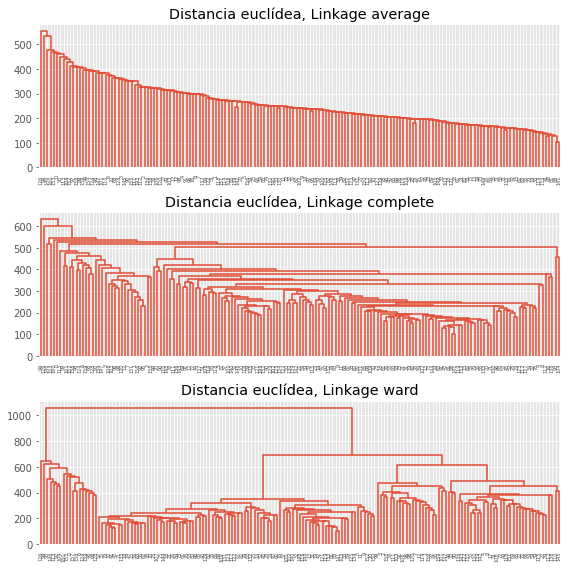

In [ ]:
# Dendrogramas
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout();

The following dendogram shows the distribution of the model that has been developed, based on the variable: "altura_corte", the user will be able to adapt the threshold to the requirements.

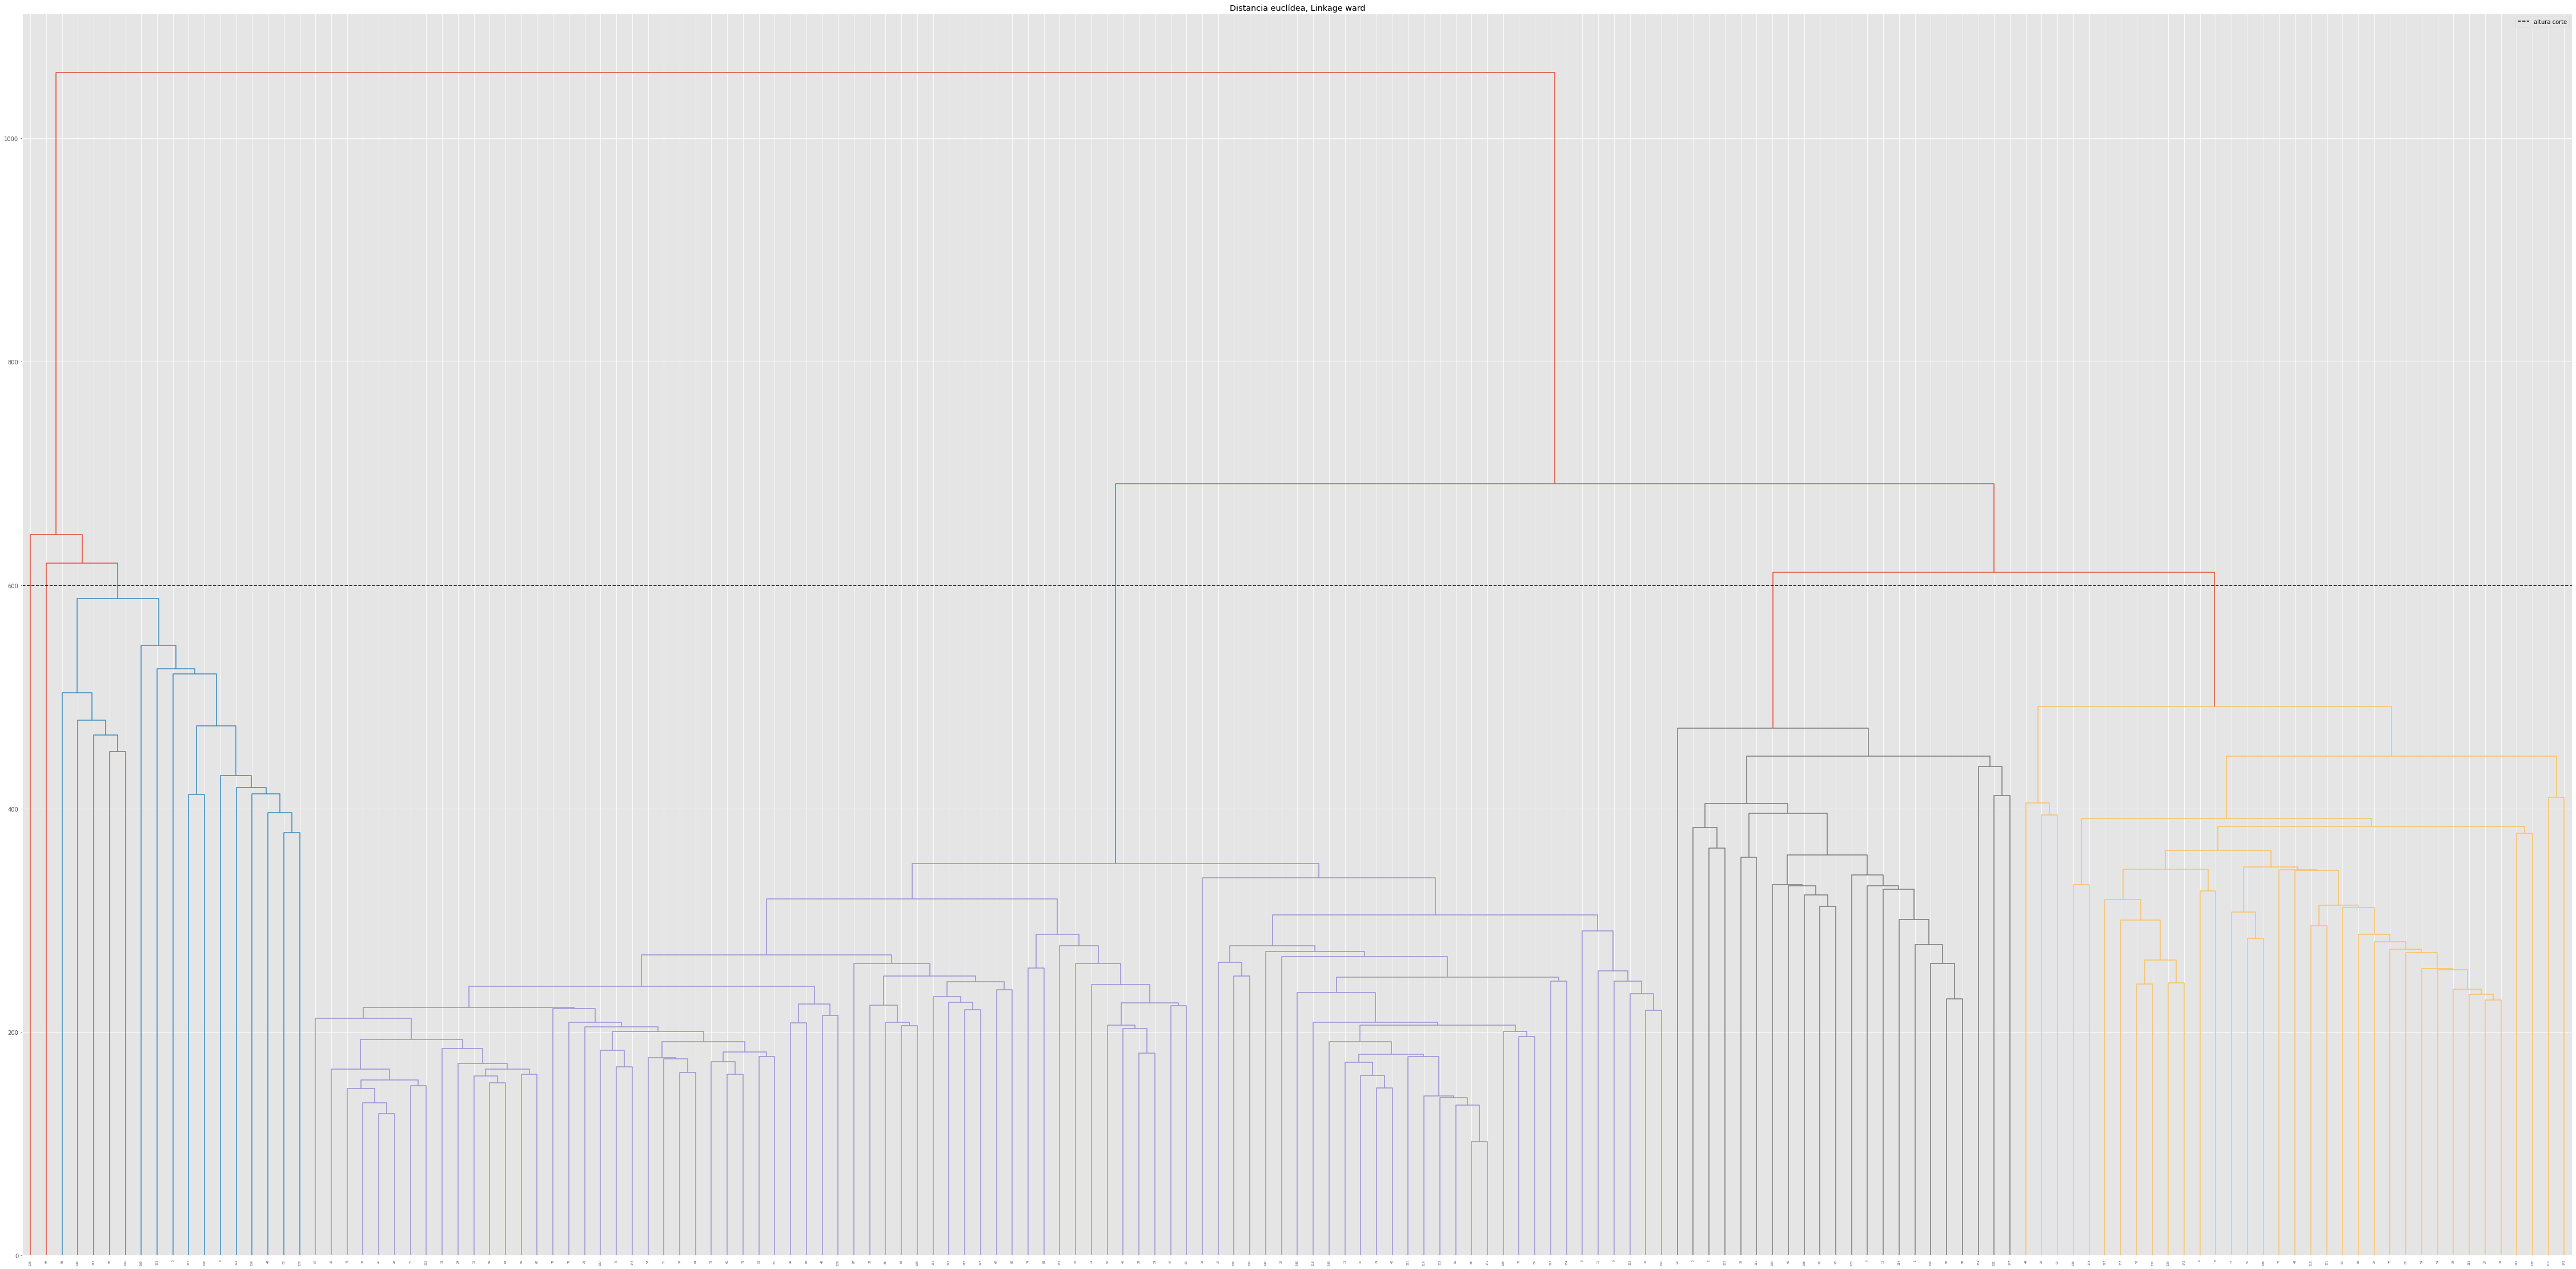

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(80, 40))
altura_corte = 600
plot_dendrogram(modelo_hclust_ward, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

Several results obtained from the model:

In [ ]:
print(modelo_hclust_ward.n_leaves_)
print(modelo_hclust_ward.n_connected_components_)
print(modelo_hclust_ward.distances_)
print(modelo_hclust_ward.labels_)
print(modelo_hclust_ward.compute_full_tree)

161
1
[ 101.60728632  126.7503225   134.58129314  136.83099325  141.36121723
  142.76929885  149.36154361  149.98854354  151.84152906  154.63750399
  157.10567346  160.42641939  161.15306566  161.98647773  162.14878193
  163.92897168  166.77903022  166.9246119   168.56083678  171.93695214
  173.133424    173.64451283  176.13032543  177.23939974  177.85266406
  178.13198574  180.19575176  181.30230395  181.85824005  183.75063898
  185.00922736  191.1147002   191.40125792  193.30566456  195.99227625
  200.41799959  200.48546486  203.18768382  204.47078675  205.50174451
  205.95955791  205.99197366  207.92714106  208.57870707  208.63088244
  208.67738236  212.42362817  214.89821392  219.45148861  219.80556556
  220.75323963  221.96609879  223.35609324  223.81979241  224.83634542
  226.29810189  226.72259785  228.42127827  229.51821792  231.86020397
  233.62866403  234.44262489  235.20451945  237.98049196  238.44813468
  240.83446893  242.18032094  242.98696977  243.97480732  245.20573796


In [ ]:
modelo_hclust_ward.labels_

array([159, 139, 147, 135, 105, 129,  83, 101,  85,  90, 112,  86, 103,
       140,  94, 149,  93, 119, 130, 153, 123, 138, 137, 122, 141,  80,
       145, 104, 133, 125, 157, 148, 154, 126, 142, 143,  81, 158, 107,
        96, 113, 160, 132, 102, 108, 124, 118,  53, 115,  89,  46, 136,
       120,  67,  84,  73, 151, 114,  68,  41, 106, 146,  98,  59, 121,
        52, 150,  97,  69, 117, 116, 152,  72,  70,  82,  34,  64,  87,
       110,  76, 134,  78,  92,  62, 144, 131,  57,  79,  39, 127,  71,
        99,  50,  88,  40,  42,  58,  33,  20,  60,  43, 100,  56,  95,
       111,  61, 109,  65,  66,  32,  51,  48,  35, 128,  30,  49,  28,
        55,  63, 155,  91,  16,  27,  25,  45,  44,  31,  21,  29,  54,
        75,  24,  74, 156,  26,  36,  47,  14,  13,  22,  17,  19,  77,
        38,  15,   6,  12,  37,  23,   7,   9,  18,  11,   8,  10,   3,
         4,   5,   2,   1,   0])

In [ ]:
modelo_hclust_ward.n_clusters_

161

Now, once visualized the model and decided the optimal threshold, is time to run the clustering for the exact amount of clusters that the user will be expecting. The result will be the expected clustering, which will be studied further in R.

In [ ]:
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            #distance_threshold = 0,
                            n_clusters         = 4                           
                     )

In [ ]:
modelo_hclust_ward.fit_predict(X_scaled)

array([0, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 2, 1, 0, 2, 1, 2, 1, 2,
       1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 0, 2, 3, 2, 0, 2, 1, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2, 0,
       1, 1, 1, 0, 0, 0, 0])

Silhouette method to determine the optimal number of clusters in certain dataset, in this case it is developed for educational purposes more than its usefulness. Further explanation of the technique in the report of this project.

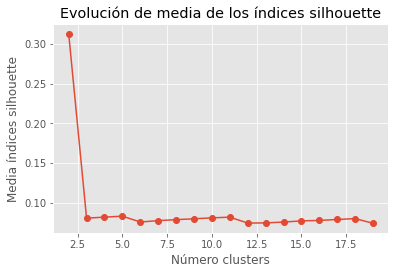

In [ ]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 20)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
                    affinity   = 'euclidean',
                    linkage    = 'ward',
                    n_clusters = n_clusters
             )

    cluster_labels = modelo.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');